In [0]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow.contrib.eager as tfe

keras = tf.keras
tf.enable_eager_execution()

In [0]:
!git clone https://github.com/magus96/Neural-Differential-Equations

Cloning into 'Neural-Differential-Equations'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 24 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [0]:
cd /content/Neural-Differential-Equations/

/content/Neural-Differential-Equations


In [0]:
from neuralode import NeuralODE

In [0]:
t = np.linspace(0, 25, 200)
h0 = tf.to_float([[1., 0.]])
W = tf.to_float([[-0.1, 1.0], [-0.2, -0.1]])

Instructions for updating:
Use tf.cast instead.


In [0]:
class Lambda(tf.keras.Model):
  def call(self,inputs,**kwargs):
    t,h=inputs
    return tf.matmul(h,W)

In [0]:
neural_ode=NeuralODE(Lambda(),t=t)
hn,states_history=neural_ode.forward(h0,return_states="numpy")
initial_path=np.concatenate(states_history)

No handles with labels found to put in legend.


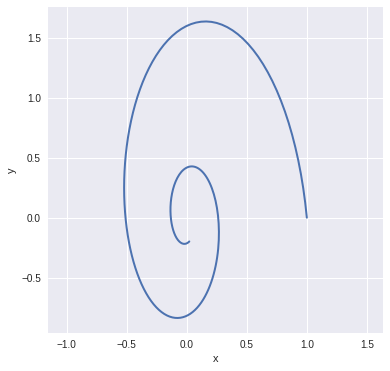

In [0]:
def plot_trajectory(trajectories,fig=True):
  if fig:
    plt.figure(figsize=(6,6))
  
  for path in trajectories:
    if type(path)==tuple:
      c,label,path=path
      plt.plot(*path.T, c, lw=2, label=label)
    else:
      plt.plot(*path.T,lw=2)
      
  plt.axis("equal")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.legend() 
  
plot_trajectory([initial_path])

In [0]:
optimizer = tf.train.MomentumOptimizer(learning_rate=1e-2, momentum=0.95)

In [0]:
def compute_gradients_and_update():
  with tf.GradientTape() as g:
    hn = neural_ode.forward(h0_var)
    g.watch(hn)
    loss = tf.reduce_sum((hn_target - hn)**2)
    
  dLoss = g.gradient(loss, hn) # same what 2 * (hN_target - hN)
  h0_reconstruction, dfdh0, dWeights = neural_ode.backward(hn, dLoss)
  optimizer.apply_gradients([(dfdh0, h0_var)])
  return loss
  
compute_gradients_and_update = tfe.defun(compute_gradients_and_update)  

In [0]:
h0_var = tf.Variable(h0)
hn_target = tf.to_float([[0., 0.5]])

  0%|          | 0/201 [00:00<?, ?it/s]

Instructions for updating:
Colocations handled automatically by placer.


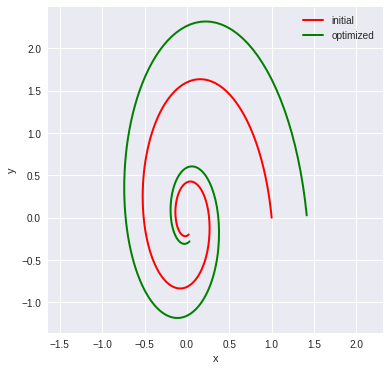

 24%|██▍       | 49/201 [00:48<00:09, 16.00it/s]

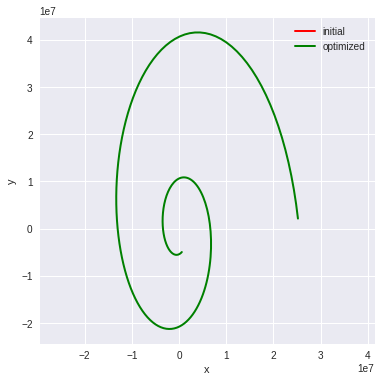

 49%|████▉     | 99/201 [00:52<00:05, 18.13it/s]

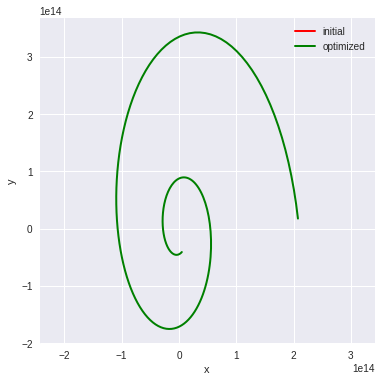

 74%|███████▍  | 149/201 [00:57<00:02, 19.06it/s]

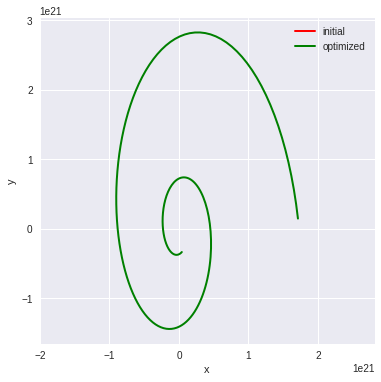

 99%|█████████▉| 199/201 [01:01<00:00, 18.69it/s]

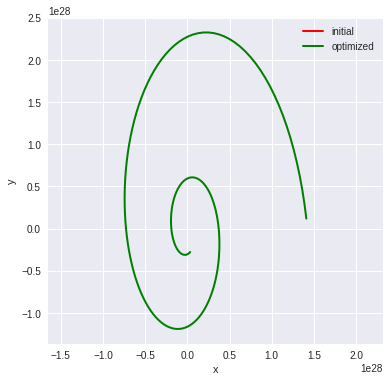

100%|██████████| 201/201 [01:02<00:00,  3.73it/s]


In [0]:
loss_history = []
for step in tqdm(range(201)):    
    loss = compute_gradients_and_update()
    loss_history.append(loss.numpy())
    
    if step % 50 == 0:        
        yN, states_history_model = neural_ode.forward(h0_var, return_states="numpy")    
        plot_trajectory([
            ("r", "initial", initial_path), 
            ("g", "optimized", np.concatenate(states_history_model))])        
        plt.show()